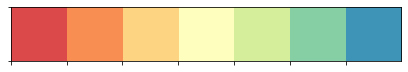

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import statsmodels.api as sm
from IPython.display import display, HTML

USE_DARK = False
palette = cmap = 'Spectral'
c0, c1, c2, c3, c4, c5, c6 = sns.color_palette(palette, 7)
sns.palplot(sns.color_palette(palette, 7))

rc = {
    'font.family': 'Source Sans Pro',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': (12, 7),
    'grid.alpha': 0,
}

if USE_DARK:
    COLORS = {
        'fg': '0.8',
        'fg_muted': '0.7',
        'bg': '0.1',
        'bg_muted': '0.2'
    }
    SNS_STYLE='dark'
else: 
    COLORS = {
        'fg': '0.1',
        'fg_muted': '0.2',
        'bg': '0.99',
        'bg_muted': '0.95',
    }
    SNS_STYLE='white'

rc.update({
    'text.color': COLORS['fg'],
    'figure.facecolor': COLORS['bg'],
    'axes.facecolor': COLORS['bg'],
    'axes.edgecolor': COLORS['bg_muted'],
    'axes.labelcolor': COLORS['fg_muted'],
    'xtick.color': COLORS['fg'],
    'ytick.color': COLORS['fg'],
    'legend.edgecolor': COLORS['bg_muted'],
})
    
sns.set(context='notebook', style=SNS_STYLE, palette=palette, rc=rc)

In [11]:
df = pd.read_csv("processed_data.csv")
print(df.shape)
for dt_col in ('created', 'author_created', 'author_joined'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    
df['posted-relative'] = pd.to_timedelta(df['created'] - df['author_joined']).dt.total_seconds() / 60
df = df.query('`posted-relative` > 0')
    
df['ask-to-ask'] = df['ask-to-ask'] == 1
df.head()

(2674, 10)


,id,content,server,channel,created,author,author_created,author_joined,posted-relative,ask-to-ask
0,8.396958e+17,"hi can anyone help me with my work, of coarse ...",Homework Help Voice,academic-help-2,2021-05-06 02:51:28.173,taki,2020-04-05 09:14:40.453,2021-05-06 02:49:40.682692,1.791505,True
1,8.396959e+17,hold on,Homework Help Voice,academic-help-2,2021-05-06 02:51:41.915,taki,2020-04-05 09:14:40.453,2021-05-06 02:49:40.682692,2.020538,False
2,8.396961e+17,NaN,Homework Help Voice,academic-help-2,2021-05-06 02:52:27.642,taki,2020-04-05 09:14:40.453,2021-05-06 02:49:40.682692,2.782655,False
3,8.396961e+17,its this but i dont know how to send a pic,Homework Help Voice,academic-help-2,2021-05-06 02:52:40.841,taki,2020-04-05 09:14:40.453,2021-05-06 02:49:40.682692,3.002638,False
4,8.396964e+17,its a assignment i have to do,Homework Help Voice,academic-help-2,2021-05-06 02:53:45.986,taki,2020-04-05 09:14:40.453,2021-05-06 02:49:40.682692,4.088388,False


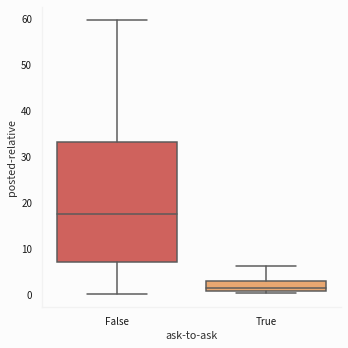

In [109]:
sns.catplot(data=df[~pd.isnull(df['posted-relative'])], x='ask-to-ask', y='posted-relative', kind='box')

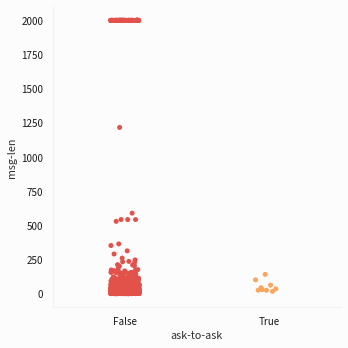

In [15]:
df['msg-len'] = [len(str(x)) if not pd.isnull(x) else 2000 for x in df['content']]
sns.catplot(data=df, x='ask-to-ask', y='msg-len')

In [27]:
num_prev = []
for i, row in df.iterrows():
    auth = row['author']
    time = row['created']
    num_prev.append(len(df.query('`author` == @auth and created < @time')))
    
df['num_prev'] = num_prev

In [34]:
df[df['ask-to-ask']]['num_prev']

0       0
336     0
1048    0
1094    0
2225    1
2226    2
2234    0
2488    1
2489    2
Name: num_prev, dtype: int64

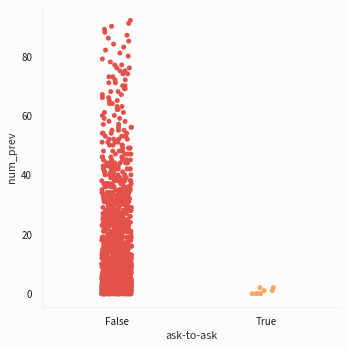

In [28]:
sns.catplot(data=df, x='ask-to-ask', y='num_prev')

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
clf = LogisticRegression()
df_subset = df.query('`posted-relative` < 5')
X = df_subset[['msg-len', 'posted-relative', 'num_prev']].values
y = df_subset['ask-to-ask']
clf.fit(X, y)
confusion_matrix(y, clf.predict(X))

array([[258,   0],
       [  8,   0]])

In [111]:
for i, row in df_subset.query('not `ask-to-ask`').iterrows():
    if i < 10:
        print(row['content'])
        print(clf.predict_proba(row[['msg-len', 'posted-relative', 'num_prev']].values.reshape(1, -1)))

hold on
[[0.95802273 0.04197727]]
nan
[[0.99893016 0.00106984]]
its this but i dont know how to send a pic
[[0.98710334 0.01289666]]
its a assignment i have to do
[[0.99443608 0.00556392]]
nan
[[9.99814929e-01 1.85071094e-04]]
here is the pic
[[0.9974585 0.0025415]]


In [112]:
for i, row in df_subset.query('`ask-to-ask`').iterrows():
    print(row['content'])
    print(clf.predict_proba(row[['msg-len', 'posted-relative', 'num_prev']].values.reshape(1, -1)))

hi can anyone help me with my work, of coarse you dont need to but if its possible, it would help alot
[[0.94371656 0.05628344]]
can someone help me with my study guide its Triangle Congruence
[[0.96964512 0.03035488]]
Can someone lend me a hand
[[0.92190921 0.07809079]]
are you guys good at math?
[[0.94753914 0.05246086]]
hey, can any of you guys help me with math homework? I have a bit of assignments and theyre due in 2 hours. I'll buy nitro to whoever helps me
[[0.98439296 0.01560704]]
Can anybody help me with a history question?
[[0.89591195 0.10408805]]
I NEED SOMEONE TO HELP ME ASAP
[[0.90912094 0.09087906]]
I NEED HELP DOING HOMEWORKS FOR MATH
[[0.94735591 0.05264409]]


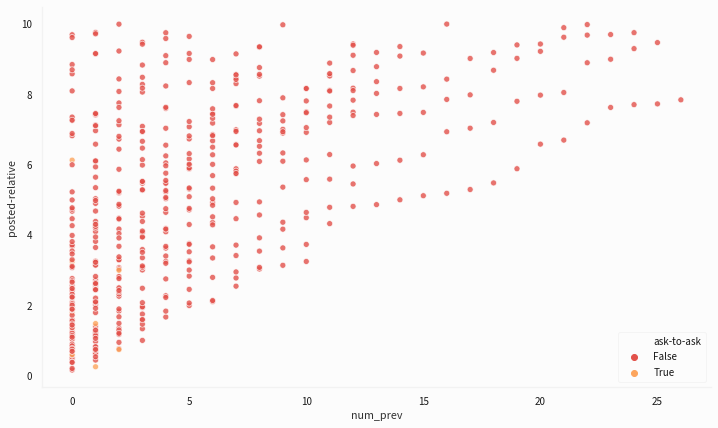

In [29]:
sns.scatterplot(data=df.query('`posted-relative` < 10'), x='num_prev', y='posted-relative', hue='ask-to-ask', alpha=0.8)

In [130]:
import spacy
nlp = spacy.load('en_core_web_sm')
textcat = nlp.add_pipe("textcat")
data = [{'text': text.lower(), 'cats': {'GOOD': not a2a, 'BAD': a2a}} 
        for i, (text, a2a) in df_subset[['content', 'ask-to-ask']].iterrows()
       if not pd.isnull(text)]

In [132]:
import json
def write(lojson, out):
    with open(out, 'w') as outfile:
        for row in lojson:
            outfile.write(json.dumps(row) + '\n')

In [136]:
write(data, 'textcat_demo/assets/data.jsonl')

In [137]:
nlp = spacy.load('textcat_demo/training/model-best')

In [153]:
nlp("help me".lower()).cats

{'GOOD': 0.0012059422442689538, 'BAD': 0.9987940788269043}